In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [63]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Student\Downloads\bithi\Job-Placement-Prediction-Salary-Estimation\Data\ds_salaries.csv")
df.head(10)


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L
6,6,2020,SE,FT,Lead Data Scientist,190000,USD,190000,US,100,US,S
7,7,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
8,8,2020,MI,FT,Business Data Analyst,135000,USD,135000,US,100,US,L
9,9,2020,SE,FT,Lead Data Engineer,125000,USD,125000,NZ,50,NZ,S


In [64]:
# Overview of dataset
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [65]:
# Remove top 1% salary outliers
q99 = df['salary_in_usd'].quantile(0.99)
df = df[df['salary_in_usd'] < q99]


In [66]:
# Step 1: Calculate upper cap using mean + 3 * std
mean_salary = df['salary_in_usd'].mean()
std_salary = df['salary_in_usd'].std()
upper_cap = mean_salary + 3 * std_salary

print(f"🔹 Capping salaries above: {round(upper_cap, 2)}")

# Step 2: Clip extreme salary values to this cap
df['salary_in_usd'] = np.where(df['salary_in_usd'] > upper_cap, upper_cap, df['salary_in_usd'])

# Step 3: Create log-transformed target
df['log_salary'] = np.log1p(df['salary_in_usd'])

# Done ✅ — You’ve handled outliers without deleting any rows!


🔹 Capping salaries above: 290637.41


In [67]:
# 🔹 Drop unused columns: 'salary' and 'salary_currency'
df_cleaned = df.drop(columns=['salary', 'salary_currency'])

# 🔹 Convert 'work_year' to string (optional for encoding later)
df_cleaned['work_year'] = df_cleaned['work_year'].astype(str)

# 🔹 Check unique values in categorical columns (optional check)
for col in ['experience_level', 'employment_type', 'job_title', 'employee_residence', 
            'company_location', 'company_size', 'work_year']:
    print(f"{col} - unique values: {df_cleaned[col].nunique()}")


experience_level - unique values: 4
employment_type - unique values: 4
job_title - unique values: 49
employee_residence - unique values: 57
company_location - unique values: 50
company_size - unique values: 3
work_year - unique values: 3


In [68]:
# 🔹 Apply one-hot encoding to categorical variables
categorical_cols = ['experience_level', 'employment_type', 'job_title', 
                    'employee_residence', 'company_location', 'company_size', 'work_year']

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print("✅ Encoded DataFrame shape:", df_encoded.shape)
df_encoded.head()


✅ Encoded DataFrame shape: (600, 167)


,Unnamed: 0,salary_in_usd,remote_ratio,log_salary,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_SG,company_location_SI,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_M,company_size_S,work_year_2021,work_year_2022
0,0,79833.0,0,11.287705,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,260000.0,0,12.468441,False,False,True,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,2,109024.0,50,11.599332,False,False,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,3,20000.0,0,9.903538,False,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,4,150000.0,50,11.918397,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False


#Log Transform Salary (Optional but Recommended)


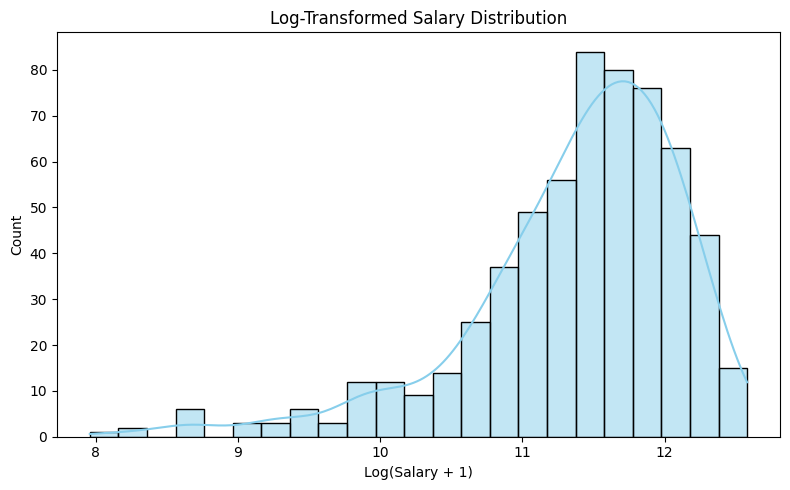

In [69]:
# Add a log-transformed salary column to original df (optional)
df['log_salary'] = np.log1p(df['salary_in_usd'])

# Plot log salary distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['log_salary'], kde=True, color='skyblue')
plt.title("Log-Transformed Salary Distribution")
plt.xlabel("Log(Salary + 1)")
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

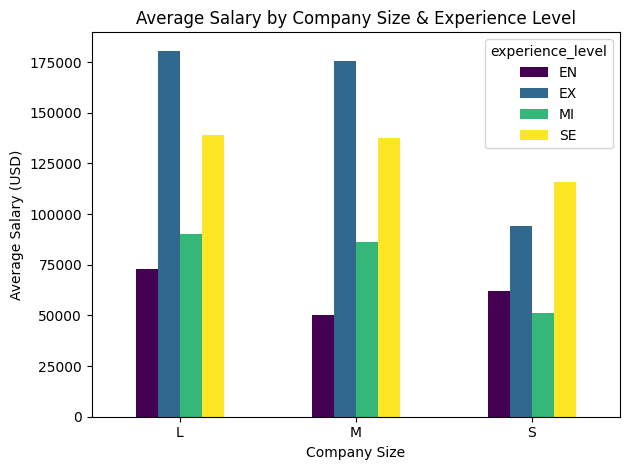

In [70]:
plt.figure(figsize=(10, 6))
grouped = df.groupby(['company_size', 'experience_level'])['salary_in_usd'].mean().unstack()
grouped.plot(kind='bar', colormap='viridis')
plt.title("Average Salary by Company Size & Experience Level")
plt.ylabel("Average Salary (USD)")
plt.xlabel("Company Size")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


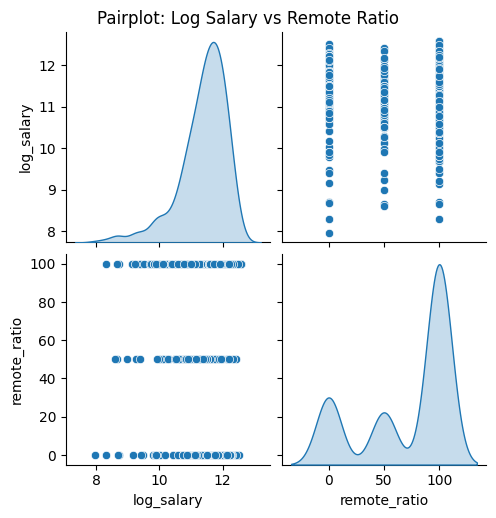

In [71]:
sns.pairplot(df[['log_salary', 'remote_ratio']], diag_kind='kde')
plt.suptitle("Pairplot: Log Salary vs Remote Ratio", y=1.02)
plt.show()


In [72]:
# Features and target
X = df_encoded.drop(columns=['salary_in_usd'])
y = df_encoded['salary_in_usd']

# Split data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (480, 166), Test shape: (120, 166)


In [73]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


In [74]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


In [75]:
def evaluate_model(name, y_true, y_pred):
    print(f"📊 {name} Performance:")
    print("R² Score       :", r2_score(y_true, y_pred))
    print("RMSE           :", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("-" * 40)

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


📊 Linear Regression Performance:
R² Score       : 0.42331793061881373
RMSE           : 42869.87519921519
----------------------------------------
📊 Random Forest Performance:
R² Score       : 0.9999294438649065
RMSE           : 474.1889033071363
----------------------------------------


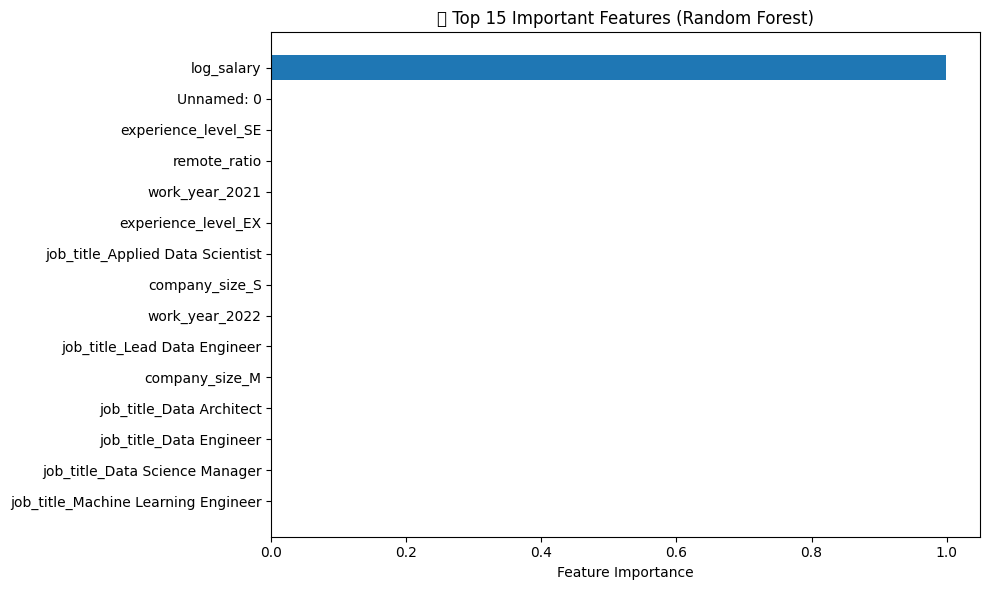

In [76]:
# Create feature importance plot
importances = rf_model.feature_importances_
features = X.columns

# Sort and plot
sorted_idx = np.argsort(importances)[-15:]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("🔍 Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.show()
